# Investigate issue #182

https://github.com/mjhoptics/ray-optics/issues/182#issue-3238200443

In [1]:
%matplotlib inline
# use widget to enable interactive figures.
#%matplotlib widget

In [2]:
isdark = False

In [3]:
from rayoptics.environment import *

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, PowerNorm, Normalize

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from rayoptics.gui import dashboards
from rayoptics.mpl.interactivelayout import InteractiveLayout

In [5]:
import numpy as np
from numpy.fft import fftshift, fft2, ifft2

from rayoptics.optical.opticalmodel import OpticalModel
from rayoptics.raytr.trace import trace_ray
from rayoptics.raytr.waveabr import transfer_to_exit_pupil
from rayoptics.elem import surface as srf
from rayoptics.elem.profiles import YToroid
from rayoptics.raytr.opticalspec import PupilSpec, FieldSpec, WvlSpec
from rayoptics.optical import model_constants as mc


def compute_sin_theta(opm, u, v, fld, wvl, exp_dst_parax):
    # trace one marginal ray at pupil coord [u,v]
    ray_pkg, trace_err = trace_ray(opm, [u, v], fld, wvl, apply_vignetting=False)

    if trace_err:
        raise RuntimeError(f"Ray trace failed: {trace_err}")

    ray_list, _, _ = ray_pkg
    pt_exit, dir_exit, _, _ = ray_list[-1]
    ray_seg = (pt_exit, dir_exit)
    exp_pt, exp_dir, *_ = transfer_to_exit_pupil(last_interface, ray_seg, exp_dst_parax)
    return np.hypot(exp_dir[0], exp_dir[1])

## Create the optical model

In [6]:
# ----------------------------
# Optical Model Setup
# ----------------------------
opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']

# Set model properties
opm.radius_mode = True
sm.do_apertures = False

# Optical specifications
epd = 3.0
osp['pupil'] = PupilSpec(osp, key=['object', 'epd'], value=epd)
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=0.0, flds=[0.0])
osp['wvls'] = WvlSpec([(546.074, 1.0)], ref_wl=0)

# Surface 0: Object
sm.gaps[0].thi = 1e100

# Surface 1: STOP (Pupil)
sm.add_surface([0.0, 0.0, 'Air'], sd=1.5)
sm.set_stop()

# Surface 2: YToroid Anterior
gamma_rot = 0.
#gamma_rot = 30.
sm.add_surface([18., 2., 1.5], sd=5.0)
sm.ifcs[sm.cur_surface].profile = YToroid(r=18.0, rR=20.0, cc=0.0)
sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('dec and return')
sm.ifcs[sm.cur_surface].decenter.euler = np.array([0., 0., gamma_rot])  # rotate 30° Z

# Surface 3: Spherical Posterior
sm.add_surface([-20., 0., 'Air'], sd=5.0)

opm.update_model()

# Optimize Img position using paraxial ray tracing
ar = opm['analysis_results']
ax_ray = ar['parax_data'].ax_ray
prx_img_dist = -ax_ray[-1][mc.ht] / ax_ray[-1][mc.slp]
sm.gaps[-1].thi = prx_img_dist
exp_dst = pm.sys[-1][1]  # Distance from image to exit pupil
last_interface = sm.ifcs[-1]  # Image plane interface

opm.update_model()

sm.list_model()

# Ray-trace
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)
exp_dst_parax = ar['parax_data'].fod.exp_dist


# Entrance-pupil radius in mm
epd = osp['pupil'].value
rp = epd / 2.0

n = 361
phis = np.linspace(0, 2 * np.pi, n)  # 1° sampling

sin_thetas = np.empty(n)
for i, phi in enumerate(phis):
    u = rp * np.cos(phi)
    v = rp * np.sin(phi)
    sin_thetas[i] = compute_sin_theta(opm, u, v, fld, wvl, exp_dst_parax)

# find max & min
i_max = np.argmax(sin_thetas)
i_min = np.argmin(sin_thetas)

phi_max = phis[i_max] * 180 / np.pi
phi_min = phis[i_min] * 180 / np.pi

sin_max = sin_thetas[i_max]
sin_min = sin_thetas[i_min]

wfno_max = 1 / (2 * sin_max)
wfno_min = 1 / (2 * sin_min)

              r            t        medium     mode   zdr      sd
  Obj:     0.000000 1.00000e+100       air      dummy  1      1.0000
 Stop:     0.000000      0.00000       air             1      1.5000
    2:    18.000000      2.00000   n:1.500             1      5.0000
    3:   -20.000000      18.5714       air             1      5.0000
  Img:     0.000000      0.00000                dummy  1      1.0000


In [7]:
print(f"{wfno_max=:6.3f}   {wfno_min=:6.3f}")

wfno_max= 4.230   wfno_min= 4.465


## Model listings

In [8]:
sm.list_sg()

               r               mode              type          y       alpha
                       t           medium
  Obj:      0.00000            dummy
                1.00000e+100          air
 Stop:      0.00000                 
                     0.00000          air
    2:      18.0000                      dec and return     0.0000     0.0000
                     2.00000      n:1.500
    3:     -20.0000                 
                     18.5714          air
  Img:      0.00000            dummy


In [9]:
pm.first_order_data()

efl               19.29
f                 19.29
f'                19.29
ffl              -18.64
pp1              0.6429
bfl               18.57
ppk             -0.7143
pp sep           0.6429
f/#               6.429
m              1.11e-16
red          -5.185e+98
obj_dist         1e+100
obj_ang               1
enp_dist             -0
enp_radius          1.5
na obj         1.5e-100
n obj                 1
img_dist          18.57
img_ht           0.3366
exp_dist         -1.379
exp_radius        1.552
na img         -0.07778
n img                 1
optical invariant      0.02618


In [10]:
set_vignetting(opm)

In [11]:
listobj(osp)

aperture: object epd; value=   3.00000
field: object angle; value=   0.00000
x,y=0.00 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000
is_relative=False, is_wide_angle=False
central wavelength=  546.0740 nm
wavelength (weight) =  546.0740 (1.000)*
focus shift=0.0



In [12]:
sag_r20, tan_r20 = trace_astigmatism(opm, fld, wvl, 0.)
print(f"astigmatism: {sag_r20=:6.3f}, {tan_r20=:6.3f}")

astigmatism: sag_r20= 1.090, tan_r20=-0.000


## Lens layout

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


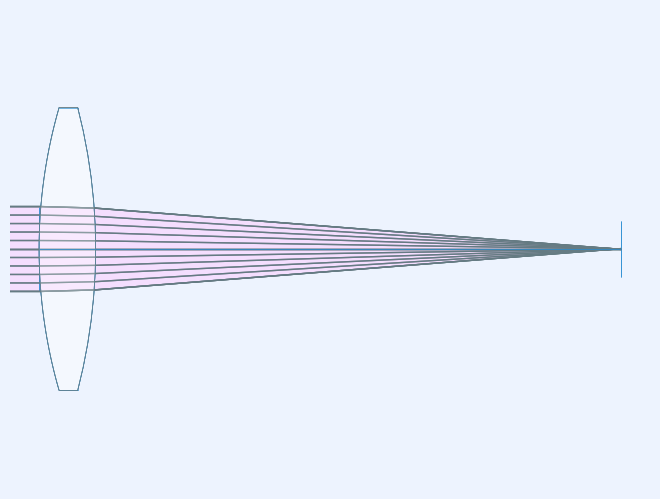

In [13]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_ray_fans=True, is_dark=False).plot()

# Diffraction MTF

In [14]:
def perfect_MTF(nu, nu_cutoff):
    """ Circular pupil, on-axis """
    phi = np.arccos(cos_phi:=(nu/nu_cutoff))
    MTF_nu = (2/np.pi)*(phi - np.sin(phi)*cos_phi)
    return MTF_nu

In [15]:
f0 = osp['fov'].fields[0]
wvl = osp['wvls'].central_wvl

## Define sampling and calculate scales

In [16]:
maxdim = 1024
n_pupil = 512
#n_airy = 8

In [17]:
maxdim, n_pupil, n_airy = analyses.psf_sampling(n=maxdim, n_pupil=n_pupil)
print(f"{maxdim=},   {n_pupil=},   {n_airy=}")

maxdim=1024,   n_pupil=512,   n_airy=5


In [18]:
d_max = maxdim//2

## anamorphic pupil calculations

In [19]:
from rayoptics.raytr.trace import trace_boundary_rays_at_field
rim_rays = trace_boundary_rays_at_field(opm, f0, wvl, use_named_tuples=True)

In [20]:
wl_sys = opm.nm_to_sys_units(osp['wvls'].central_wvl)
NA_x = abs(rim_rays[1].ray[-2].d[0])
nu_cutoff_x = 2 * NA_x / wl_sys
NA_y = abs(rim_rays[3].ray[-2].d[1])
nu_cutoff_y = 2 * NA_y / wl_sys

In [21]:
img_freqs_x = np.linspace(-nu_cutoff_x, nu_cutoff_x, maxdim)
MTF_ideal_x = [perfect_MTF(nu, nu_cutoff_x) for nu in img_freqs_x]

In [22]:
img_freqs_y = np.linspace(-nu_cutoff_y, nu_cutoff_y, maxdim)
MTF_ideal_y = [perfect_MTF(nu, nu_cutoff_y) for nu in img_freqs_y]

In [23]:
# compensate for internal oversize factor of 1.02
init_vig = [f0.vux, f0.vlx, f0.vuy, f0.vly]
modified_vig = [1 - (1 - v)/1.02 for v in init_vig]
f0.vux, f0.vlx, f0.vuy, f0.vly = tuple(modified_vig)

In [24]:
vig_x = 1 - NA_y/NA_x
f0.vux = f0.vlx = vig_x
opm.update_model()

In [25]:
print(f"{NA_x=:6.4f}   {nu_cutoff_x=:6.1f}\n{NA_y=:6.4f}   {nu_cutoff_y=:6.1f}")

NA_x=0.0741   nu_cutoff_x= 271.6
NA_y=0.0782   nu_cutoff_y= 286.5


## Define the wavefront

In [26]:
wfr_grid = analyses.RayGrid(opm, num_rays=n_pupil, clip_rays=True, f=f0, wl=wvl)
delta_x, delta_xp = analyses.calc_psf_scaling(wfr_grid, n_pupil, maxdim)

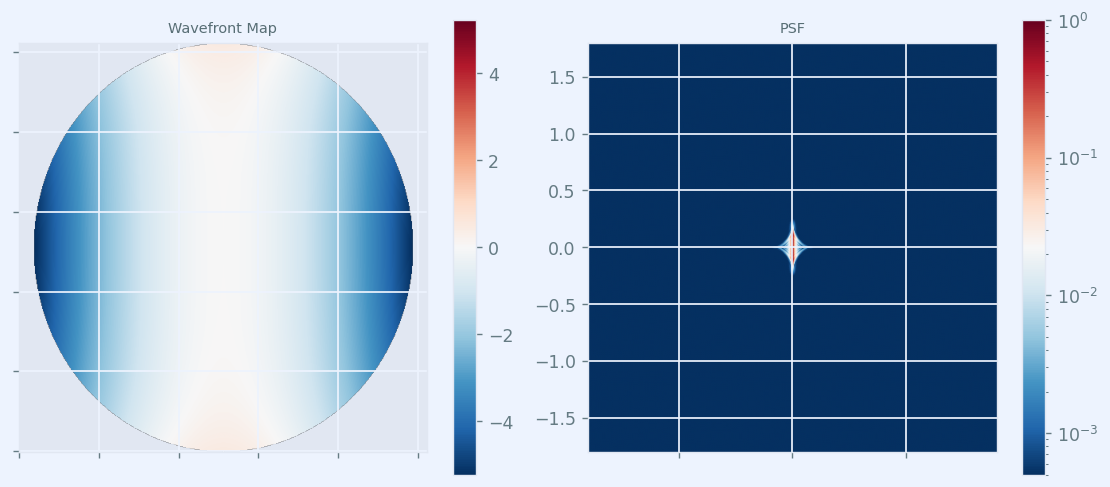

In [27]:
wfr = Wavefront(wfr_grid, user_scale_value=None, do_contours=False,
                title='Wavefront Map') #, cmap="BrBG_r")

diff_psf = DiffractionPSF(wfr_grid, maxdim, # cmap="BrBG_r",   # cmap=cc.m_fire,
                          yaxis_ticks_position='left', title='PSF', norm=LogNorm(vmin=5e-4)) #norm=PowerNorm(gamma=0.5, vmin=2e-3))

fig_psf = plt.figure(FigureClass=AnalysisFigure, data_objs=[wfr_grid], subplots=[wfr, diff_psf],
                     grid=(1, 2), figsize=[9, 4], dpi=125, tight_layout=True, is_dark=isdark).plot()

## Loop over focus

In [28]:
foc_lite = np.array([-.125, .375, 1.0])
foc_dense = np.arange(-.25, 1.25, .125)
foc_list = foc_lite

In [29]:
foci = []
for foc in foc_list:
    wfr_grid.foc = foc
    diff_psf.update_data(build='refocus')
    psf = diff_psf.AP
    
    mtf = abs(fftshift(ifft2(fftshift(psf))))
    mtf_max = np.nanmax(mtf)
    mtf = mtf/mtf_max
    
    foci.append((psf, mtf))

### plot full PSF

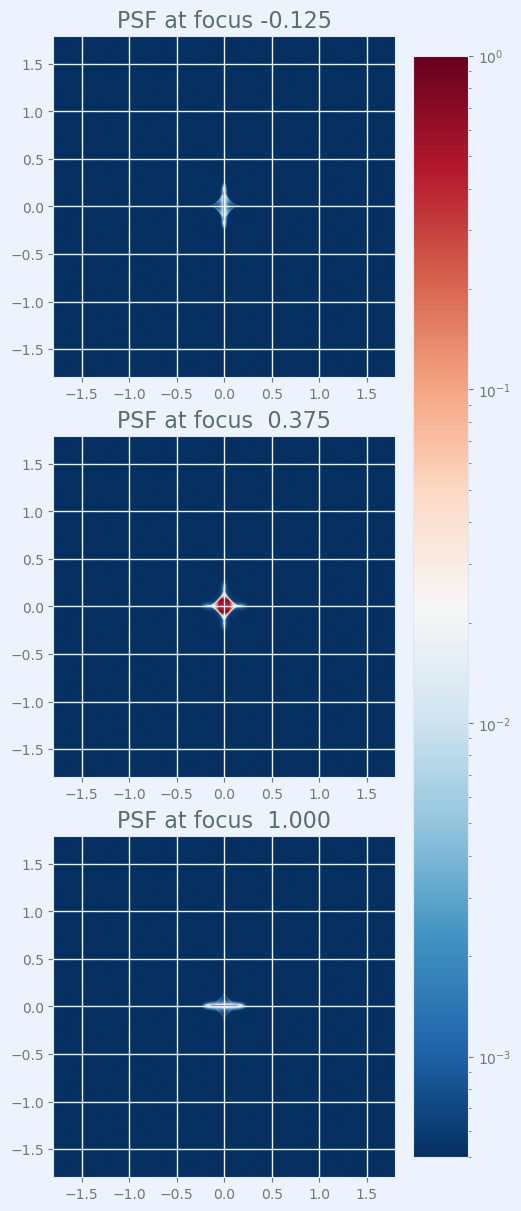

In [30]:
fig4, ax4 = plt.subplots(len(foci),1, figsize=(5, 4*len(foci)), layout="constrained")
for i_foc, foc_pkg in enumerate(foci):
    psf, mtf = foc_pkg
    image_scale = diff_psf.image_scale
    hmap = ax4[i_foc].imshow(psf,
                             origin='lower',
                             norm=diff_psf.norm,
                             cmap="RdBu_r",
                             extent=[-image_scale, image_scale,
                                     -image_scale, image_scale],
                             #**diff_psf.plot_kwargs
                             )
    if i_foc == 0:
        ax4[i_foc].figure.colorbar(hmap, ax=ax4, use_gridspec=True)

    ax4[i_foc].set_title(f"PSF at focus {foc_list[i_foc]:6.3f}")
    ax4[i_foc].set_aspect('equal')

### plot full MTF

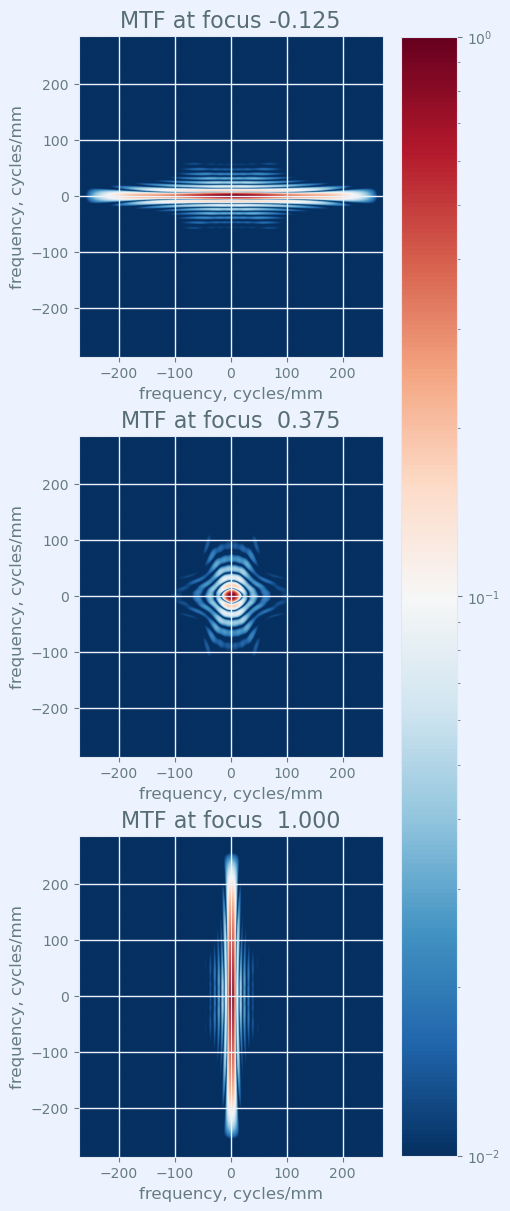

In [31]:
fig3, ax3 = plt.subplots(len(foci),1, figsize=(5, 4*len(foci)), layout="constrained")             # Create a figure containing a single Axes.
# Plot some data on the Axes.
for i_foc, foc_pkg in enumerate(foci):
    psf, mtf = foc_pkg
    hmap = ax3[i_foc].imshow(mtf,
                      origin='lower',
                      norm=LogNorm(vmin=1e-2), 
                      extent=[-nu_cutoff_x, nu_cutoff_x,
                              -nu_cutoff_y, nu_cutoff_y],
                      cmap="RdBu_r",
                      )
    if i_foc == 0:
        ax3[i_foc].figure.colorbar(hmap, ax=ax3, use_gridspec=True)
    ax3[i_foc].set_xlabel('frequency, cycles/mm')
    ax3[i_foc].set_ylabel('frequency, cycles/mm')
    ax3[i_foc].set_title(f"MTF at focus {foc_list[i_foc]:6.3f}")
    ax3[i_foc].set_aspect('equal')

### plot MTF vs frequency

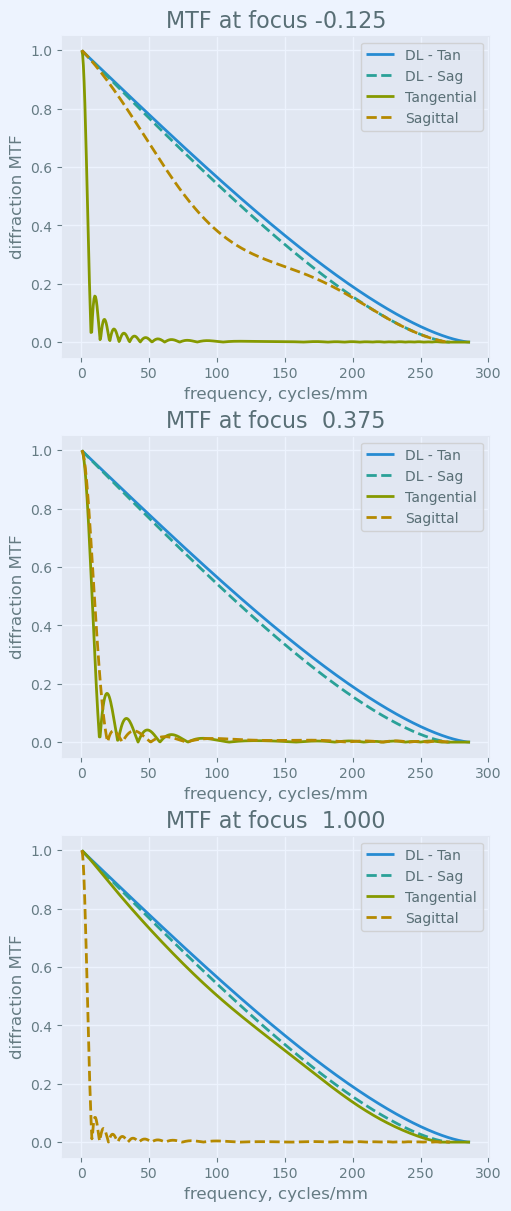

In [32]:
fig2, ax2 = plt.subplots(len(foci),1, figsize=(5, 4*len(foci)), layout="constrained")             # Create a figure containing a single Axes.
# Plot some data on the Axes.
for i_foc, foc_pkg in enumerate(foci):
    psf, mtf = foc_pkg
    tan, sag = mtf[:,d_max], mtf[d_max,:]
    tan, sag = tan / np.nanmax(tan), sag / np.nanmax(sag) # Normalized
    ax2[i_foc].plot(img_freqs_y[d_max:], MTF_ideal_y[d_max:], label='DL - Tan')
    ax2[i_foc].plot(img_freqs_x[d_max:], MTF_ideal_x[d_max:], '--', label='DL - Sag')
    ax2[i_foc].plot(img_freqs_y[d_max:], tan[d_max:], label='Tangential')
    ax2[i_foc].plot(img_freqs_x[d_max:], sag[d_max:], '--', label='Sagittal')
    ax2[i_foc].set_xlabel('frequency, cycles/mm')
    ax2[i_foc].set_ylabel('diffraction MTF')
    ax2[i_foc].set_title(f"MTF at focus {foc_list[i_foc]:6.3f}")
    ax2[i_foc].legend()